[0.46842285571837267, 1.3571368885014452, 1.447563597632116, 1.9298390762410904, 1.8455893127200504, 1.6330741575102237, 1.6671766933506749, 1.2351216129861378, 1.4427564961147146, 2.242071850166096, 2.2162260600413566, 1.8924516363569248, 2.4672035942127417, 2.3862278011228297, 2.0498372138795533, 1.8071382042882715, 1.5793804093135448, 1.7322752052436936, 1.3764396521370663, 1.5902434631688018, 1.6248058909600172, 1.5500707163968668, 1.1385742429236914, 2.3542365324811185, 3.262849536679408, 2.332403207554627, 1.0391608653976212, 1.2433549247316293, 1.4959614988884329, 1.4342156637685173, 1.5096438819919826, 1.9311821797644515, 1.913072644080436, 1.7124794691681022, 1.8065769687823352, 1.6322639976258142, 2.116842762891383, 3.3109090338643066, 3.7942162131920334, 3.116139865755056]


(array([ 1.,  1.,  8., 11.,  9.,  5.,  1.,  1.,  2.,  1.]),
 array([0.46842286, 0.80100219, 1.13358153, 1.46616086, 1.7987402 ,
        2.13131953, 2.46389887, 2.79647821, 3.12905754, 3.46163688,
        3.79421621]),
 <a list of 10 Patch objects>)

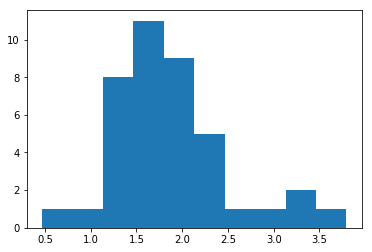

In [151]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.tight_layout()
import time

class site:
    def __init__(self, position, properties):
        self.index = position
        for name,value in properties.items():
            setattr(self, name, value)
        
#want to change this to take any distribution
class AndersonHopp:
    def __init__(self, inL, inT, inW):
        self.W = inW
        self.t = inT
        self.L = int(inL)
        self.system = []
        self.spectrum = []
        self.eigen = []
        self.x = []
        for i in range(self.L):
            self.x.append(np.exp(i * 1j * math.pi * 2 / self.L))
        self.x = np.diag(self.x)
        self.H = np.zeros((self.L,self.L)) + self.t*(np.diag(np.ones(self.L-1),1) + np.diag(np.ones(self.L-1),-1))
        for i in range(self.L):
            self.system.append(site(i, {'t':inT, 'U':np.random.uniform(-self.W/2,self.W/2)}))
            self.H[i,i] = self.system[i].U
        self.solve()
        
        
        
    def solve(self):
        temp = np.linalg.eigh(self.H)
        self.spectrum = temp[0]
        self.eigen = temp[1]
#        for wave in self.eigen:
 #           out, sub = plt.subplots(1)
  #          sub.plot(wave)



    def reparam(self, Wnew):
        self.W = Wnew
        self.rescramble()
    
    def rescramble(self, Wsingle = None):
        if Wsingle == None:
            Wsingle = self.W
        for i in range(self.L):
            self.system[i].U = np.random.Uniform(-Wsingle/2,Wsingle/2)
            self.H[i,i] = self.system[i].U
        self.solve()
    
    def CoM(self, index=-.5):
        out = []
        if not(index+.5):
            for i in range(self.L):
                out.append(self.L/(2*math.pi) * np.imag(np.log(np.vdot(self.eigen[i], np.dot(self.x, self.eigen[i])))))
        else:
            if index == int(index) and abs(index + .5)<self.L:
                return (self.L/(2*math.pi) * np.imag(np.log(np.vdot(self.eigen[index], np.dot(self.x, self.eigen[index])))))
            else:
                print("CoM passed bad index")
                return
        return out
    
    def locLength(self, index=-.5):
        out = []
        wf = []
        loclens = []
        if not(index+.5):
            centers = np.rint(self.CoM())
            for i in range(self.L):
                wf = self.eigen[i]
                loclens.append(0)
                for j in range(-int(self.L/2),int(self.L/2)):
                    loclens[-1] += np.sqrt((j*wf[int(centers[i])+j])**2)
            print(loclens)
            return loclens
        else:
            if index == int(index) and abs(index + .5)<self.L:
                wf = self.eigen[index]
                loclen = 0
                center = np.rint(self.CoM(index))
                for j in range(-int(self.L/2),int(self.L/2)):
                    loclen += np.sqrt((j*wf[int(centers[index])+j])**2)
                return loclen
            else:
                print("locLength passed bad index")
                return
        return out
    
#    def WFout(self):
 #       vector = []
  #      for site in self.system:
   #         vector.append(site.wf)
    #    return vector
    
    def E(self):
        E=0
        for i in range(int(-self.L/2),int(self.L/2)):
            E+=self.system[i].wf*self.Hi(i)
        return E
    
    def Hi(self, i):
        return (t*(self.system[i-1].wf + self.system[i+1].wf) + self.system[i].U * self.system[i].wf)
    
#    def timeEvolve(self, dt):
#        wfnext = [0]*L
 #       for i in range(int(-L/2),int(L/2)):
  #          wfnext[i] = exp(j*dt*Hi(i))


L = 40
t = 1
W = 50

gaussian = AndersonHopp(L, t, W)

#print(gaussian.eigen[4])
#print(gaussian.CoM(),gaussian.spectrum)
out, sub = plt.subplots(1)
sub.hist(gaussian.locLength())

#for sites in test.system:
#    print(sites.t)
#    print(sites.U)

